In [3]:
!pip install tensorflow_docs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 12.0 MB/s eta 0:00:00


In [13]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [14]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [15]:
# movenet 가져오고 입력 이미지에서 좌표 뽑는 곳, pc 테스트용

# get movenet
model_name = "movenet_lightning" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  # elif "movenet_thunder_f16" in model_name:
  #   !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
  #   input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  # elif "movenet_thunder_int8" in model_name:
  #   !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
  #   input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

Processing test_address.jpg


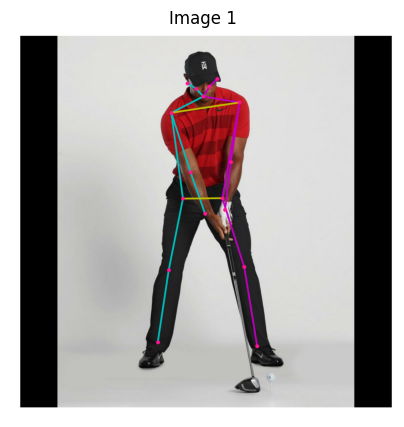

Results for test_address have been saved to 'test_address_keypoints.json'
Processing test2.jpg


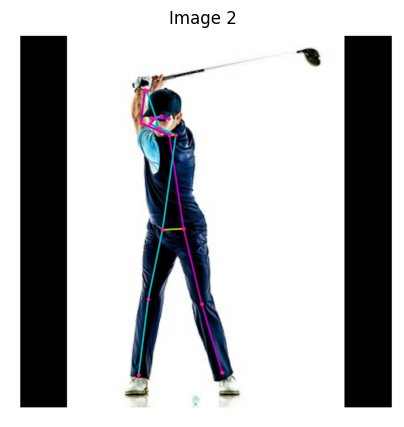

Results for test2 have been saved to 'test2_keypoints.json'
All keypoints data: [{'image_id': 1, 'person': 1, 'Keypoints': [{'Y': 0.16281864047050476, 'X': 0.49257999658584595}, {'Y': 0.13599419593811035, 'X': 0.5091631412506104}, {'Y': 0.14156118035316467, 'X': 0.47341808676719666}, {'Y': 0.1149614006280899, 'X': 0.530242383480072}, {'Y': 0.1273716688156128, 'X': 0.4501379430294037}, {'Y': 0.17867928743362427, 'X': 0.5904216766357422}, {'Y': 0.20655445754528046, 'X': 0.40669554471969604}, {'Y': 0.33871161937713623, 'X': 0.5673969984054565}, {'Y': 0.36689481139183044, 'X': 0.4584031105041504}, {'Y': 0.46802324056625366, 'X': 0.5513644218444824}, {'Y': 0.478007435798645, 'X': 0.4974685609340668}, {'Y': 0.43659576773643494, 'X': 0.5440738201141357}, {'Y': 0.4377744197845459, 'X': 0.4380008578300476}, {'Y': 0.6219029426574707, 'X': 0.6031135320663452}, {'Y': 0.6299843788146973, 'X': 0.39973247051239014}, {'Y': 0.8346149325370789, 'X': 0.6378850936889648}, {'Y': 0.8244311213493347, 'X': 0.

In [36]:
import csv
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the input size expected by the model
input_size = 192  # Example input size, adjust based on your model's requirement

# Function to run inference on a single image
def process_image(image_path, image_id):
    print(f"Processing {image_path}")

    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    # Resize and pad the image to fit the model's expected input size
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference
    keypoints_with_scores = movenet(input_image)

    # Convert keypoints_with_scores tensor to a NumPy array and ensure type is float
    keypoints_with_scores_np = keypoints_with_scores.astype(float)

    image_keypoints_data = []
    for person_id, person in enumerate(keypoints_with_scores_np[0]):
        person_data = {
            "image_id": image_id,
            "person": person_id + 1,
            "Keypoints": []
        }
        for keypoint_id, keypoint in enumerate(person):
            keypoint_data = {
                "Y": float(keypoint[0]),
                "X": float(keypoint[1]),
            }
            person_data["Keypoints"].append(keypoint_data)
        image_keypoints_data.append(person_data)

    # Visualize the predictions on the image
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(display_image, 1280, 1280), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)
    plt.figure(figsize=(5, 5))
    plt.imshow(output_overlay)
    plt.axis('off')
    plt.title(f'Image {image_id}')
    plt.show()

    # Save results to individual JSON file
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    json_filename = f'{base_name}_keypoints.json'
    with open(json_filename, 'w') as json_file:
        json.dump(image_keypoints_data, json_file, indent=4)

    print(f"Results for {base_name} have been saved to '{json_filename}'")

    return image_keypoints_data

# Function to process multiple images
def process_multiple_images(image_paths):
    all_keypoints_data = []
    for idx, image_path in enumerate(image_paths):
        image_data = process_image(image_path, idx + 1)
        all_keypoints_data.extend(image_data)
    return all_keypoints_data

# List of input image paths
image_paths = [
    "test_address.jpg",
    "test2.jpg"
    # Add more image paths here
]

# Process all images
all_keypoints_data = process_multiple_images(image_paths)

# Print the results
print("All keypoints data:", all_keypoints_data)

# Save all results to a single JSON file (optional)
with open('all_images_keypoints.json', 'w') as json_file:
    json.dump(all_keypoints_data, json_file, indent=4)

print("Combined results for all images have been saved to 'all_images_keypoints.json'")

KeyError: 'file_name'

In [57]:
import numpy as np
import json

# Load the saved keypoints JSON data
with open('normalized_pose_data_4.json', 'r') as json_file:
    keypoints_json_data = json.load(json_file)

# Function to flatten the keypoints data into a feature vector (X, Y, Confidence)
def keypoints_to_features(person_data):
    features = []
    for keypoint in person_data["Keypoints"]:
        features.append(keypoint["X"])
        features.append(keypoint["Y"])
    return np.array(features)

# Assuming you're processing multiple people or images, loop through them
X_test_all = []
for person in keypoints_json_data:
    X_test_all.append(keypoints_to_features(person))

# Convert to NumPy array
X_test_all = np.array(X_test_all, dtype=np.float32)

print("Formatted feature vectors for model input:", X_test_all)


Formatted feature vectors for model input: [[0.55727947 0.1998999  0.567451   ... 0.7090776  0.44395423 0.6911637 ]
 [0.55727947 0.1998999  0.5672097  ... 0.60763866 0.51224625 0.60033995]
 [0.55727947 0.1998999  0.5712817  ... 0.76975536 0.46470553 0.7598044 ]
 ...
 [0.55727947 0.1998999  0.55808926 ... 0.5990115  0.52524334 0.580149  ]
 [0.55727947 0.1998999  0.5626497  ... 0.66213983 0.53105056 0.65374035]
 [0.55727947 0.1998999  0.56170446 ... 0.6028485  0.6804804  0.60517293]]


In [53]:
import numpy as np
import tensorflow as tf

def load_tflite_model(model_path, input_data):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    return output_data

def process_input_string(input_string):
    # Extract the numeric values from the input string
    values = input_string.split('[')[2:]  # Split by '[' and ignore the first two elements
    values = [v.split(']')[0] for v in values]  # Remove the closing brackets

    # Convert string values to floats
    X_test_all = [[float(num) for num in value.split()] for value in values]

    return np.array(X_test_all, dtype=np.float32)

# Your input string
input_string = "Formatted feature vectors for model input: [[0.49258 0.16281864 0.50916314 0.1359942 0.4734181 0.14156118 0.5302424 0.1149614 0.45013794 0.12737167 0.5904217 0.17867929 0.40669554 0.20655446 0.567397 0.33871162 0.4584031 0.3668948 0.5513644 0.46802324 0.49746856 0.47800744 0.5440738 0.43659577 0.43800086 0.43777442 0.60311353 0.62190294 0.39973247 0.6299844 0.6378851 0.83461493 0.37026656 0.8244311 ] [0.35022044 0.23657984 0.36196488 0.22113392 0.35272586 0.22062254 0.39998227 0.22231792 0.38001215 0.21584824 0.40162617 0.26768506 0.41898984 0.26658863 0.3252846 0.23437473 0.37437767 0.24917662 0.33484992 0.14562765 0.34057254 0.14691284 0.43973076 0.5188894 0.3829682 0.5217261 0.48850924 0.7216399 0.3443559 0.7088679 0.54351264 0.9068586 0.3184487 0.9130113 ]]"

# Process the input string
X_test_all = process_input_string(input_string)

# Print the shape of the processed input
print("Shape of X_test_all:", X_test_all.shape)

# Paths to your TFLite models
svm_model_path = "pose_classification_model_4.tflite"
mlp_model_path = "pose_classification_model_8.tflite"

# Make predictions for each data point
for i, data_point in enumerate(X_test_all):
    # Reshape the data point to match the model's input shape
    input_data = np.expand_dims(data_point, axis=0)

    # Make predictions using the SVM and MLP models
    svm_prediction = load_tflite_model(svm_model_path, input_data)
    mlp_prediction = load_tflite_model(mlp_model_path, input_data)

    # Print the results for each data point
    print(f"\nPredictions for data point {i+1}:")
    print("SVM Prediction:", svm_prediction)
    print("MLP Prediction:", mlp_prediction)


Shape of X_test_all: (2, 34)

Predictions for data point 1:
SVM Prediction: [[0.46770677 0.5168057  0.01114723 0.00434034]]
MLP Prediction: [[0.00200536 0.00369221 0.07891779 0.9153846 ]]

Predictions for data point 2:
SVM Prediction: [[0.56505144 0.43018663 0.00320141 0.0015605 ]]
MLP Prediction: [[0.02015242 0.11001159 0.3576182  0.51221776]]


In [66]:
import numpy as np
import tensorflow as tf

def load_tflite_model(model_path, input_data):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    return output_data

# Assuming X_test_all is defined here directly as a NumPy array
# X_test_all = np.array([[0.55727947, 0.1998999,  0.567451,   0.12345678, 0.6789123, 0.7090776,  0.44395423, 0.6911637],
#                         [0.55727947, 0.1998999,  0.5672097,  0.98765432, 0.6789123, 0.60763866, 0.51224625, 0.60033995],
#                         [0.55727947, 0.1998999,  0.5712817,  0.31415926, 0.6789123, 0.76975536, 0.46470553, 0.7598044],
#                         [0.55727947, 0.1998999,  0.55808926, 0.31415926, 0.6789123, 0.5990115, 0.52524334, 0.580149],
#                         [0.55727947, 0.1998999,  0.5626497,  0.31415926, 0.6789123, 0.66213983, 0.53105056, 0.65374035],
#                         [0.55727947, 0.1998999,  0.56170446, 0.31415926, 0.6789123, 0.6028485, 0.6804804, 0.60517293]])

# Print the shape of the processed input
print("Shape of X_test_all:", X_test_all.shape)

# Paths to your TFLite models
svm_model_path = "pose_classification_model_4.tflite"
mlp_model_path = "pose_classification_model_8.tflite"

# Initialize lists to store predictions
svm_predictions = []
mlp_predictions = []

# Make predictions for each data point
for i, data_point in enumerate(X_test_all):
    # Reshape the data point to match the model's input shape
    input_data = np.expand_dims(data_point, axis=0)

    # Make predictions using the SVM and MLP models
    svm_prediction = load_tflite_model(svm_model_path, input_data)
    mlp_prediction = load_tflite_model(mlp_model_path, input_data)

    # Store predictions in respective lists
    svm_predictions.append(svm_prediction.flatten().tolist())  # Flatten and convert to list
    mlp_predictions.append(mlp_prediction.flatten().tolist())  # Flatten and convert to list

# Combine the predictions into integrated outputs
integrated_output = {
    'svm_predictions': svm_predictions,
    'mlp_predictions': mlp_predictions
}

# Print the integrated predictions
print("\nIntegrated Predictions:")
print("SVM Predictions:", integrated_output['svm_predictions'])
print("MLP Predictions:", integrated_output['mlp_predictions'])


Shape of X_test_all: (1844, 34)

Integrated Predictions:
SVM Predictions: [[0.36296358704566956, 0.6184901595115662, 0.014623541384935379, 0.003922729752957821], [0.22730791568756104, 0.7328014373779297, 0.03390003740787506, 0.00599053455516696], [0.34891656041145325, 0.6332799196243286, 0.01420715544372797, 0.0035964094568043947], [0.2645820677280426, 0.6978785991668701, 0.030974343419075012, 0.006565012037754059], [0.25827300548553467, 0.7046617865562439, 0.030789479613304138, 0.006275704130530357], [0.2786979079246521, 0.6846714615821838, 0.029827475547790527, 0.00680311257019639], [0.22389256954193115, 0.7342368364334106, 0.03577412664890289, 0.0060964482836425304], [0.269717812538147, 0.695845365524292, 0.028497006744146347, 0.005939787719398737], [0.2516471743583679, 0.708447277545929, 0.03309518098831177, 0.0068104262463748455], [0.2638721764087677, 0.7052150368690491, 0.025775205343961716, 0.00513768196105957], [0.24752072989940643, 0.7171950340270996, 0.0296785831451416, 0.005

predictions [[0.36296359 0.61849016 0.01462354 0.00392273]
 [0.22730792 0.73280144 0.03390004 0.00599053]
 [0.34891656 0.63327992 0.01420716 0.00359641]
 ...
 [0.30669433 0.67547882 0.01482677 0.00300009]
 [0.19957608 0.77795142 0.01998465 0.0024879 ]
 [0.10730693 0.82034767 0.06582739 0.00651802]]
n_samples 1844
perplexity_value 30
predictions [[0.00234657 0.00335211 0.07053492 0.92376637]
 [0.00189374 0.00162331 0.04553483 0.95094812]
 [0.00123083 0.00166085 0.05267562 0.94443268]
 ...
 [0.00356626 0.00480625 0.07169532 0.91993213]
 [0.00238575 0.00341092 0.06542844 0.92877495]
 [0.00190247 0.00136112 0.03582554 0.96091092]]
n_samples 1844
perplexity_value 30


<ipython-input-59-0310d0744e58>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_results[:, 0], tsne_results[:, 1], cmap='viridis', alpha=0.7)


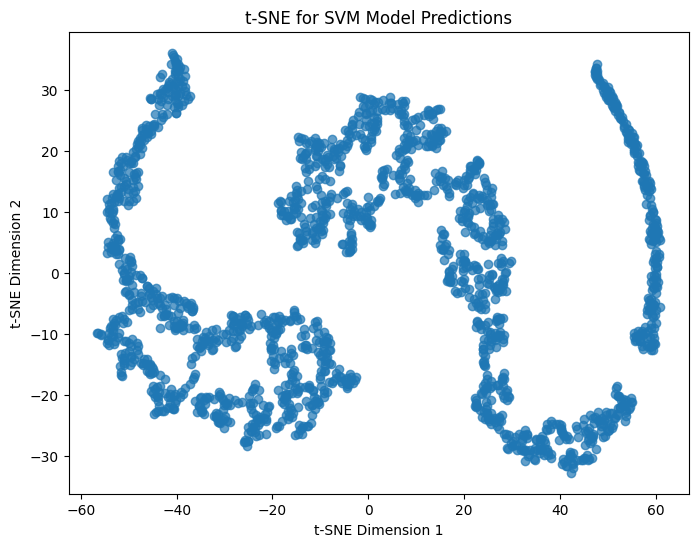

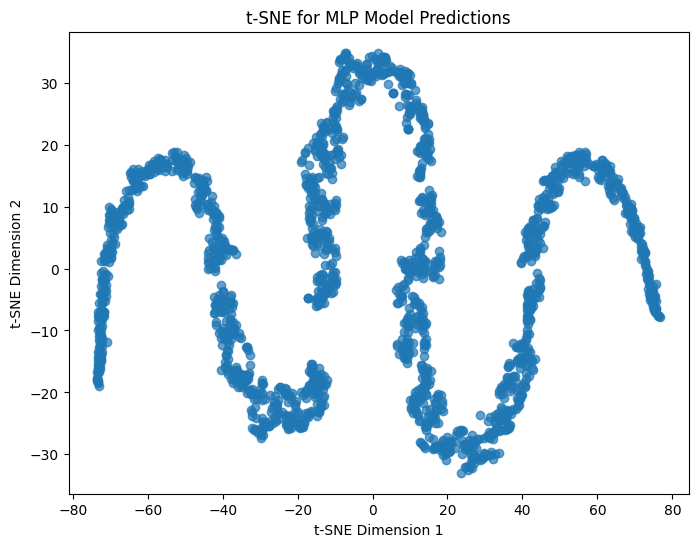

In [59]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Apply t-SNE to reduce the dimensionality of the predictions
def apply_tsne(predictions):
    print("predictions",predictions)
    n_samples = len(predictions) #.shape #[0]  # Get the number of samples
    print("n_samples",n_samples)
    # Ensure perplexity is less than the number of samples
    perplexity_value = min(30, n_samples - 1)
    print("perplexity_value",perplexity_value)
    # Apply t-SNE with an appropriate perplexity value
    tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
    tsne_results = tsne.fit_transform(predictions)
    return tsne_results

# Compute t-SNE for SVM and MLP predictions
svm_tsne = apply_tsne(np.array(svm_predictions))  # Ensure predictions are in NumPy array format
mlp_tsne = apply_tsne(np.array(mlp_predictions))

# Function to plot the t-SNE results
def plot_tsne(tsne_results, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], cmap='viridis', alpha=0.7)
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

# Plot the t-SNE results for both models
plot_tsne(svm_tsne, "t-SNE for SVM Model Predictions")
plot_tsne(mlp_tsne, "t-SNE for MLP Model Predictions")


In [2]:
# load model
import tensorflow as tf
import numpy as np

# Function to load a TFLite model and make predictions
def load_tflite_model(tflite_model_path, input_data):
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Load data for prediction
# Assume `X_test` is your test dataset
# X_test = np.array(...)

# Load SVM and MLP models (paths to your tflite models)
svm_model_path = "pose_classification_model_4.tflite"
mlp_model_path = "pose_classification_model_8.tflite"

# Make predictions using the models
svm_predictions = load_tflite_model(svm_model_path, X_test)
mlp_predictions = load_tflite_model(mlp_model_path, X_test)


NameError: name 'X_test' is not defined

In [1]:
# show comp and vis
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce the dimensionality of the predictions
def apply_tsne(predictions):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(predictions)
    return tsne_results

# Compute t-SNE for SVM and MLP predictions
svm_tsne = apply_tsne(svm_predictions)
mlp_tsne = apply_tsne(mlp_predictions)

# Visualize the t-SNE embeddings
def plot_tsne(tsne_results, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

# Assuming you have the true labels of the test dataset
# labels = y_test

# Plot the t-SNE results for both models
plot_tsne(svm_tsne, labels, "t-SNE for SVM Model Predictions")
plot_tsne(mlp_tsne, labels, "t-SNE for MLP Model Predictions")

NameError: name 'svm_predictions' is not defined

In [ ]:
[
            {
              "Keypoint ID": 0,
              "Y": 0.1998999040023779,
              "X": 0.5572794732116567,
              "Confidence Score": 0.38429954648017883
            },
            {
              "Keypoint ID": 1,
              "Y": 0.1857140283481573,
              "X": 0.5674509760402547,
              "Confidence Score": 0.3766421675682068
            },
            {
              "Keypoint ID": 2,
              "Y": 0.18855988191528072,
              "X": 0.5435571428798543,
              "Confidence Score": 0.3990709185600281
            },
            {
              "Keypoint ID": 3,
              "Y": 0.1848350982562994,
              "X": 0.5841666516326772,
              "Confidence Score": 0.5482219457626343
            },
            {
              "Keypoint ID": 4,
              "Y": 0.19071208642883053,
              "X": 0.5350731071494924,
              "Confidence Score": 0.5129073262214661
            },
            {
              "Keypoint ID": 5,
              "Y": 0.24788459347648373,
              "X": 0.6238423046134817,
              "Confidence Score": 0.5817942023277283
            },
            {
              "Keypoint ID": 6,
              "Y": 0.2511663358108496,
              "X": 0.5107928272746908,
              "Confidence Score": 0.5316048860549927
            },
            {
              "Keypoint ID": 7,
              "Y": 0.3229065756694769,
              "X": 0.6461649593376028,
              "Confidence Score": 0.3576698303222656
            },
            {
              "Keypoint ID": 8,
              "Y": 0.32904674815101376,
              "X": 0.5030016657375204,
              "Confidence Score": 0.23619356751441956
            },
            {
              "Keypoint ID": 9,
              "Y": 0.3073511342899298,
              "X": 0.6697701868080007,
              "Confidence Score": 0.4405936896800995
            },
            {
              "Keypoint ID": 10,
              "Y": 0.391438684930036,
              "X": 0.5274413880370962,
              "Confidence Score": 0.124388687312603
            },
            {
              "Keypoint ID": 11,
              "Y": 0.4263933520214056,
              "X": 0.5869002398513662,
              "Confidence Score": 0.5152628421783447
            },
            {
              "Keypoint ID": 12,
              "Y": 0.4233699064151739,
              "X": 0.5177237745784627,
              "Confidence Score": 0.29457661509513855
            },
            {
              "Keypoint ID": 13,
              "Y": 0.5784742455379461,
              "X": 0.6054537352584707,
              "Confidence Score": 0.58955317735672
            },
            {
              "Keypoint ID": 14,
              "Y": 0.5684495191471075,
              "X": 0.4699011501335012,
              "Confidence Score": 0.333624929189682
            },
            {
              "Keypoint ID": 15,
              "Y": 0.7090776185886358,
              "X": 0.6185544785522329,
              "Confidence Score": 0.44528064131736755
            },
            {
              "Keypoint ID": 16,
              "Y": 0.691163740624616,
              "X": 0.4439542349838125,
              "Confidence Score": 0.6086346507072449
            }
          ]

In [60]:
print("SVM Predictions:", svm_predictions)
print("MLP Predictions:", mlp_predictions)


SVM Predictions: [[0.36296358704566956, 0.6184901595115662, 0.014623541384935379, 0.003922729752957821], [0.22730791568756104, 0.7328014373779297, 0.03390003740787506, 0.00599053455516696], [0.34891656041145325, 0.6332799196243286, 0.01420715544372797, 0.0035964094568043947], [0.2645820677280426, 0.6978785991668701, 0.030974343419075012, 0.006565012037754059], [0.25827300548553467, 0.7046617865562439, 0.030789479613304138, 0.006275704130530357], [0.2786979079246521, 0.6846714615821838, 0.029827475547790527, 0.00680311257019639], [0.22389256954193115, 0.7342368364334106, 0.03577412664890289, 0.0060964482836425304], [0.269717812538147, 0.695845365524292, 0.028497006744146347, 0.005939787719398737], [0.2516471743583679, 0.708447277545929, 0.03309518098831177, 0.0068104262463748455], [0.2638721764087677, 0.7052150368690491, 0.025775205343961716, 0.00513768196105957], [0.24752072989940643, 0.7171950340270996, 0.0296785831451416, 0.005605681333690882], [0.26163169741630554, 0.698736071586608

In [61]:
perplexity_value = min(5, n_samples - 1)  # Change this value based on the number of samples


NameError: name 'n_samples' is not defined

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('SVM Predictions Distribution')
plt.hist(np.array(svm_predictions).flatten(), bins=30, alpha=0.7, color='blue')
plt.xlabel('Prediction Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.title('MLP Predictions Distribution')
plt.hist(np.array(mlp_predictions).flatten(), bins=30, alpha=0.7, color='orange')
plt.xlabel('Prediction Value')
plt.ylabel('Frequency')

plt.show()


predictions [[ 0.96620218 -0.9580979  -0.67275276 -0.66475164]
 [-0.70204336  0.70951748  0.43328952  0.51250329]
 [ 0.79345681 -0.74233938 -0.69664406 -0.85053425]
 ...
 [ 0.27422272 -0.12672621 -0.66109212 -1.19003631]
 [-1.04307968  1.36818219 -0.36514457 -1.48163813]
 [-2.17777305  1.9866744   2.2652098   0.81281169]]
n_samples 1844
perplexity_value 30
predictions [[-0.62777523 -0.19006513  0.35204136 -0.25457333]
 [-0.98372994 -0.94837463 -0.88514466  0.92188323]
 [-1.50482407 -0.93190922 -0.53176689  0.6398875 ]
 ...
 [ 0.33097475  0.44777327  0.40946629 -0.42052389]
 [-0.59697919 -0.1642676   0.09933567 -0.03779641]
 [-0.97686871 -1.06338319 -1.36563113  1.35308433]]
n_samples 1844
perplexity_value 30


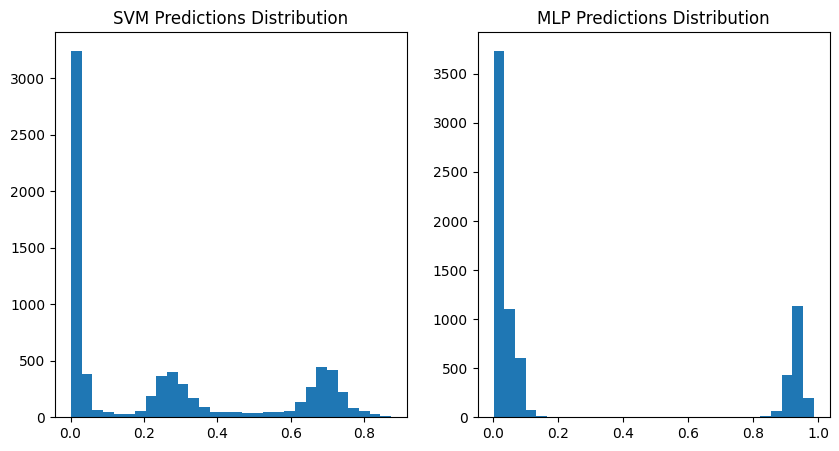

In [63]:
# Assuming you have some class labels
class_labels = ["Class1", "Class2", "Class3"]  # Replace with actual labels

# Example: creating an array of class labels corresponding to the predictions
# For demonstration, we'll assume 0, 1, 2 are class labels
labels = np.array([0, 1, 2] * (len(svm_predictions) // 3))  # Example labeling, modify as needed

# Example: Visualizing predictions with labels
plt.figure(figsize=(12, 6))
plt.scatter(np.array(svm_predictions)[:, 0], np.array(svm_predictions)[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(ticks=[0, 1, 2], label='Class Labels')
plt.title('SVM Predictions with Class Labels')
plt.show()


predictions shape: (1844, 4)
n_samples: 1844
perplexity_value: 30
predictions shape: (1844, 4)
n_samples: 1844
perplexity_value: 30


<ipython-input-65-c72f9b021605>:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_results[:, 0], tsne_results[:, 1], cmap='viridis', alpha=0.7)


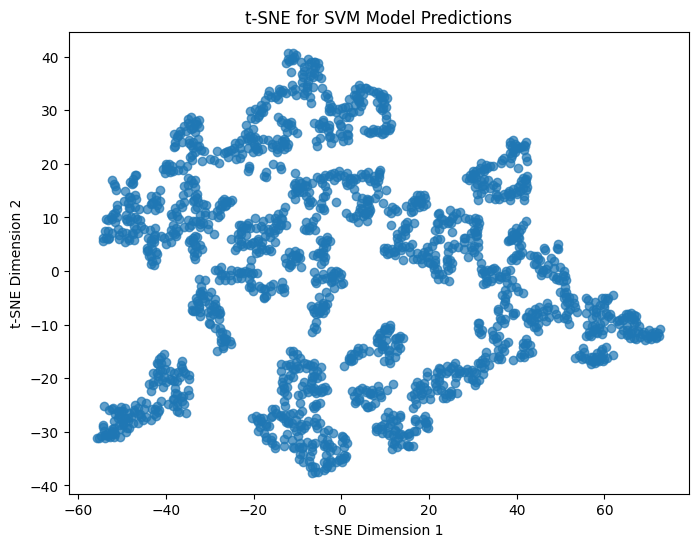

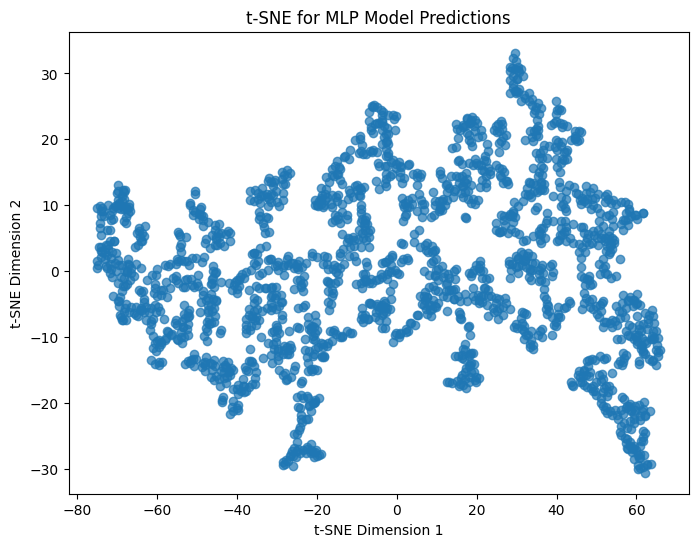

In [65]:
from sklearn.cluster import KMeans

# Assuming you want to use KMeans with 3 clusters
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(svm_predictions_normalized)
cluster_labels = kmeans.labels_

# Now use cluster labels to color your t-SNE plot
plt.figure(figsize=(8, 6))
plt.scatter(svm_tsne[:, 0], svm_tsne[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title("t-SNE for SVM Model Predictions with Clustering")
plt.colorbar()
plt.show()
